In [3]:
from pyliftover import LiftOver

In [4]:
import numpy as np
from copy import deepcopy
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bean as be

In [123]:
# Suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [5]:
plt.style.use('jr')

In [6]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams['pdf.fonttype'] = 42

# Nt-level edit coverage


## Read files


### Read LDLR exon positions


In [7]:
ldlr_exon_path="/data/pinello/PROJECTS/2021_08_ANBE/data/LDLR/exons.fa"
ldlr_seq_path="/data/pinello/PROJECTS/2021_08_ANBE/data/LDLR/seq.fa"

In [8]:
f = open(ldlr_seq_path, 'r')
pos_re = re.compile("range=(\S+)")
seq_pos = pos_re.search(f.readline()).group(1)
chrom, pos = seq_pos.split(":")
seq_start, seq_end = pos.split("-")
seq_start = int(seq_start)
seq_end = int(seq_end)
ldlr_seq = "".join(f.read().splitlines()).upper()

In [10]:
ldlr_seq=pd.Series(list(ldlr_seq), index=list(range(seq_start, seq_end+1)))


In [11]:
f=open(ldlr_exon_path,'r')
exons={}
exon_seqs = {}
#https://coding4medicine.com/backup/Python/reading-fasta-files.html
exon_id = ""
for line in f.readlines():
    exon_id_re = re.compile('>(\S+)')
    pos_re=re.compile('range=(\S+)')
    out_id = exon_id_re.search(line)
    out_pos = pos_re.search(line)
    if out_pos and out_id:
        exon_id=f"Exon {int(out_id.group(1).rsplit('_')[-1])+1}"
        exons[exon_id] = out_pos.group(1)
    if out_pos and not out_id or (not out_pos and out_id):
        raise ValueError("Only found one of two")
    else:
        exon_seqs[exon_id] = line.strip()
        

In [12]:
exons

{'Exon 1': 'chr19:11200038-11200291',
 'Exon 2': 'chr19:11210899-11211021',
 'Exon 3': 'chr19:11213340-11213462',
 'Exon 4': 'chr19:11215896-11216276',
 'Exon 5': 'chr19:11217241-11217363',
 'Exon 6': 'chr19:11218068-11218190',
 'Exon 7': 'chr19:11221328-11221447',
 'Exon 8': 'chr19:11222190-11222315',
 'Exon 9': 'chr19:11223954-11224125',
 'Exon 10': 'chr19:11224211-11224438',
 'Exon 11': 'chr19:11226770-11226888',
 'Exon 12': 'chr19:11227535-11227674',
 'Exon 13': 'chr19:11230768-11230909',
 'Exon 14': 'chr19:11231046-11231198',
 'Exon 15': 'chr19:11233850-11234020',
 'Exon 16': 'chr19:11238684-11238761',
 'Exon 17': 'chr19:11240189-11240346',
 'Exon 18': 'chr19:11241957-11244505'}

In [13]:
exons_df = pd.DataFrame(exons.values(), index=exons.keys())
exons_df[['chrom', 'pos']] = exons_df[0].str.split(":", expand=True)
exons_df[['start','end']] = exons_df['pos'].str.split("-", expand=True)

In [14]:
exons_df = exons_df[['chrom', 'start', 'end']]
exons_df['start'] = exons_df.start.astype(int)
exons_df['end'] = exons_df.end.astype(int)

In [15]:
exons_df

,chrom,start,end
Exon 1,chr19,11200038,11200291
Exon 2,chr19,11210899,11211021
Exon 3,chr19,11213340,11213462
Exon 4,chr19,11215896,11216276
Exon 5,chr19,11217241,11217363
Exon 6,chr19,11218068,11218190
Exon 7,chr19,11221328,11221447
Exon 8,chr19,11222190,11222315
Exon 9,chr19,11223954,11224125
Exon 10,chr19,11224211,11224438


### Load screen data


In [17]:
h5ad_file_path="../../results/filtered_annotated/LDLRCDS/bean_count_LDLRCDS_alleleFiltered.h5ad"

In [18]:
ldlrcds = be.read_h5ad(h5ad_file_path)

In [19]:
intron_info = ldlrcds.guides.loc[ldlrcds.guides.Region.map(lambda r: "Intron" in r)]
intron_starts = intron_info.groupby("Region").start_pos.min()
intron_ends = intron_info.groupby("Region").start_pos.max()+20

In [20]:
intron_regions = intron_info.Region.unique().tolist()

In [21]:
intron_regions

['Intron 1 DNaseHS 1', 'Intron 1 DNaseHS 2']

In [22]:
exons_df = pd.concat((exons_df, pd.DataFrame(dict(chrom="chr19", start=intron_starts[intron_regions].astype(int), end=intron_ends[intron_regions].astype(int)), index = intron_regions))
                    )

In [23]:
exons_df['size'] = exons_df.end-exons_df.start +1

In [33]:
def get_edit_rates(cds_path, base_changes=["A>G", "T>C"], allele_df_key = 'sig_allele_counts_spacer_2_7_A.G_translated_prop0.05_0.1'):
    ldlrcds = be.read_h5ad(cds_path)
    print(ldlrcds.uns.keys())
    ldlrcds_bulk = ldlrcds[:,ldlrcds.samples.bin == "bulk"]
    edit_rates = ldlrcds_bulk.get_normalized_allele_counts(allele_count_df=ldlrcds_bulk.uns['edit_counts'])
    edit_rates['mean_edit_rates'] = edit_rates.iloc[:,2:].mean(axis=1)
    edit_rates['abs_edit'] = edit_rates.edit.map(lambda e: e.get_abs_edit())
    # Max across guides, mean across replicates
    nt_edit_rates = edit_rates[['mean_edit_rates', 'abs_edit']].groupby("abs_edit").max().reset_index()
    nt_edit_rates[['pos', 'edit']] = nt_edit_rates.abs_edit.str.split(":", expand=True)
    nt_edit_rates['pos'] = nt_edit_rates.pos.astype(int)
    nt_edit_rates = nt_edit_rates.loc[(nt_edit_rates.pos > 11000000) & (nt_edit_rates.pos < 12000000)]
    nt_edit_rates = nt_edit_rates.loc[nt_edit_rates.edit.isin(base_changes),:]
    
    dup = nt_edit_rates.loc[nt_edit_rates.duplicated('pos')]
    nt_edit_rates = pd.concat([
        nt_edit_rates[~nt_edit_rates.duplicated('pos', keep=False)],
        dup])
    
    nt_edit_rates.pos = nt_edit_rates.pos.astype(int)
    
    aa_allele_df = deepcopy(ldlrcds_bulk.uns[allele_df_key])
    aa_allele_df['aa_allele'] = aa_allele_df.aa_allele.map(lambda a: a.aa_allele)
    aa_allele_df = aa_allele_df.loc[aa_allele_df.aa_allele.astype(str) != ""]
    aa_allele_df
    ldlrcds_bulk.uns['aa_only'] = aa_allele_df
    aa_edit_counts = ldlrcds_bulk.get_edit_from_allele('aa_only', allele_key='aa_allele', return_result=True)
    aa_edit_rate = ldlrcds_bulk.get_normalized_allele_counts(allele_count_df=aa_edit_counts)
    aa_edit_rate['mean_edit_rates'] = aa_edit_rate.iloc[:,2:].mean(axis=1)
    aa_edit_rate['pos'] = aa_edit_rate.edit.map(lambda e: e.pos)
    aa_edit_rate['ref_aa'] = aa_edit_rate.edit.map(lambda e: e.ref)
    aa_edit_rate['alt_aa'] = aa_edit_rate.edit.map(lambda e: e.alt)
    aa_edit_rate = aa_edit_rate.loc[aa_edit_rate.ref_aa != aa_edit_rate.alt_aa]

    return nt_edit_rates, aa_edit_rate

In [25]:
data = be.read_h5ad("../../results/filtered_annotated/LDLRCDS_CBE_SpRY/bean_count_LDLRCDS_CBE_SpRY_alleleFiltered.h5ad")

In [34]:
nt_edit_rates, aa_edit_rates = get_edit_rates("../../results/filtered_annotated/LDLRCDS/bean_count_LDLRCDS_alleleFiltered_0.05_0.1.h5ad")

dict_keys(['allele_counts', 'edit_counts', 'lfc', 'lfc_corr', 'metadata', 'repguide_mask', 'sig_allele_counts', 'sig_allele_counts_spacer', 'sig_allele_counts_spacer_2_7', 'sig_allele_counts_spacer_2_7_A.G', 'sig_allele_counts_spacer_2_7_A.G_translated', 'sig_allele_counts_spacer_2_7_A.G_translated_prop0.05_0.1', 'target_base_change', 'tiling'])


In [61]:
lo = LiftOver("hg19", "hg38")
nt_edit_rates['pos_hg38'] = nt_edit_rates.pos.map(lambda p: lo.convert_coordinate("chr19", p)[0][1])

## Plot


In [131]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style='ticks', rc=custom_params)
pal = sns.color_palette("colorblind")

edit_dfs = []

def plot_exon(ax, start_pos, end_pos, edit_df, seq=ldlr_seq, keep_legend=False):
    end_pos = min(end_pos, start_pos + 500)
    exon_padded_seq = ldlr_seq.iloc[(start_pos-100-ldlr_seq.index[0]):(end_pos+100-ldlr_seq.index[0])]
    targettable_seq=exon_padded_seq# [exon_padded_seq.isin([ref_bases])]
    targettable_pos = targettable_seq.index
    edit_df['ref_base'] = edit_df.edit.map(lambda s: s[0])
    target_info = pd.DataFrame({"base":targettable_seq, "pos": targettable_pos})
    target_info = target_info.loc[target_info.base.isin(["A", "T"])]
    edit_df = edit_df.merge(target_info, on='pos', how='right').fillna(0).rename(columns={"mean_edit_rates":"edit_rate"})
    edit_df['pos_hg38'] = edit_df.pos.map(lambda p: lo.convert_coordinate("chr19", p)[0][1])
    edit_dfs.append(edit_df.loc[(edit_df.pos >= start_pos) & (edit_df.pos <= end_pos)])
    start_pos= lo.convert_coordinate("chr19", start_pos)[0][1]
    end_pos = lo.convert_coordinate("chr19", end_pos)[0][1]
    g = sns.scatterplot(edit_df, x='pos_hg38', y='edit_rate', hue = "base", ax= ax, s=5, palette = {"A":pal[0], "T":pal[1]})
    ax.axvline(start_pos, color='black', linestyle='--')
    ax.axvline(end_pos, color='black', linestyle='--')
    ax.set_xlim((start_pos-100, start_pos + min(exons_df.iloc[:-1]['size'].max() + 100, 500)))
    ax.set_ylim((0, 1.1))
    ax.ticklabel_format(useOffset=False, style='plain')
    if not keep_legend:
        try: ax.get_legend().remove()
        except: pass
    else: 
        ax.legend(bbox_to_anchor=(1,1))
    return(g)

def plot_exons(exons_df, nt_edit_rates):
    fig, ax = plt.subplots(len(exons_df), figsize=(10, 20))
    for i in range(len(exons_df)):
        keep_legend = i == 0
        g = plot_exon(ax[i], exons_df.start[i], exons_df.end[i], nt_edit_rates, keep_legend=keep_legend)
        g.set_ylabel(exons_df.index[i], labelpad=20, rotation=90)
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].get_legend().remove()
    ax[-1].set_xlabel("Genomic position")
    #fig.legend(handles, labels, loc='upper center')
    plt.suptitle("LDLRCDS library targettable base coverage", y=1.002)
    
    plt.tight_layout()
    fig.text(0.00, 0.5, 'Edit probability by max guide', rotation='vertical')
    plt.legend(handles, labels, loc = 'center right', bbox_to_anchor = (0.05, 0, 1, 1),
           bbox_transform = plt.gcf().transFigure, title="ref base")

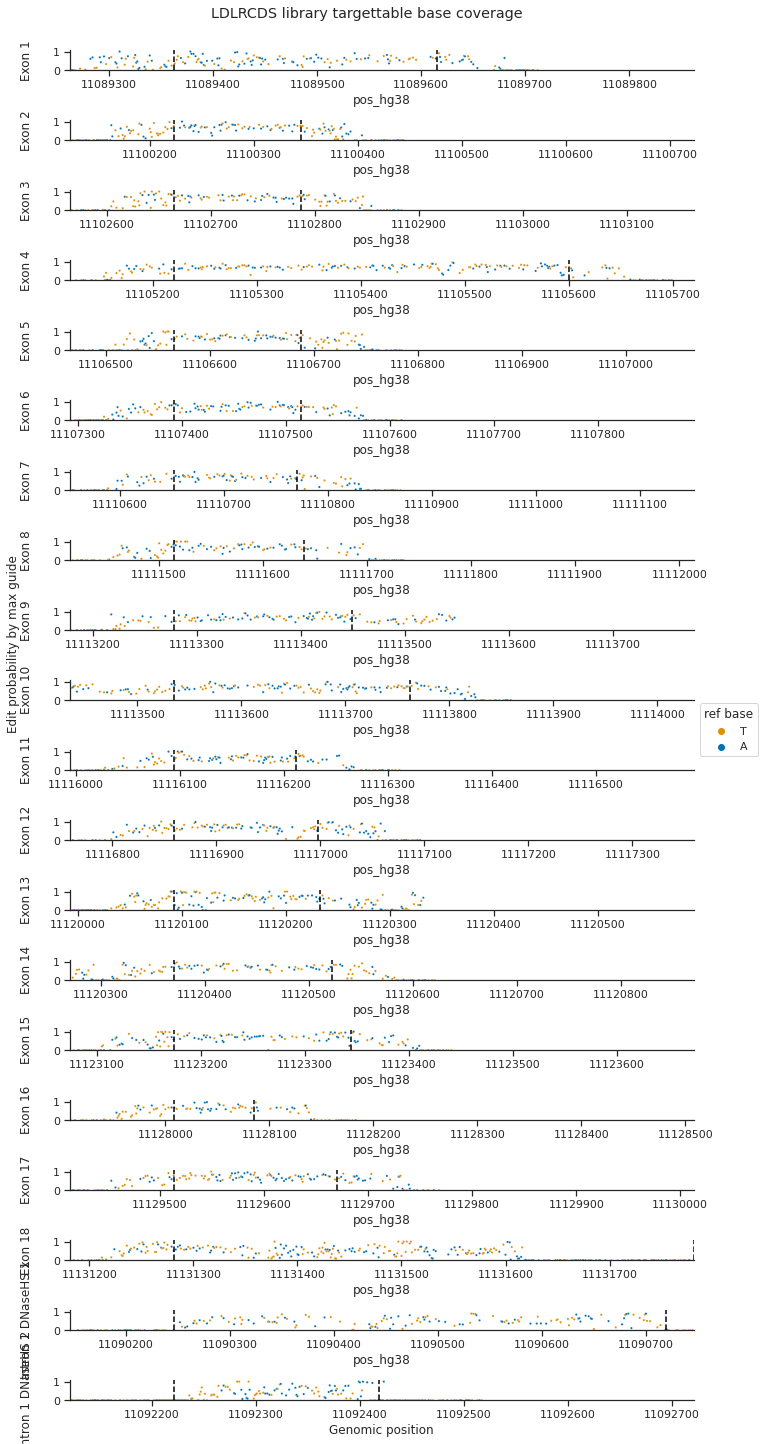

In [132]:

plot_exons(exons_df, nt_edit_rates)
plt.savefig("Sa_ABE_nt_coverage.pdf", bbox_inches="tight")

In [134]:
edf = pd.concat(edit_dfs)

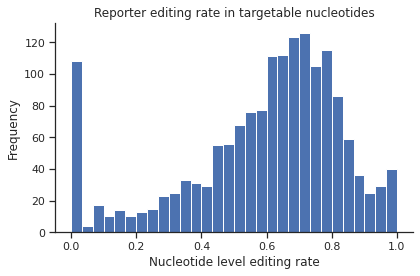

In [145]:
plt.hist(edf.edit_rate, bins=30)
plt.xlabel("Nucleotide level editing rate")
plt.ylabel("Frequency")
plt.title("Reporter editing rate in targetable nucleotides")
plt.savefig("Sb_nt_edit_rate_histogram.pdf", bbox_inches="tight")

In [140]:
sum(edf.edit_rate > 0.1)/len(edf)

0.9209074187614961

# AA-level coverage


In [111]:
max_aa_edit_rate = aa_edit_rates[['pos', 'mean_edit_rates']].groupby('pos').max()

In [112]:
max_aa_edit_rate = max_aa_edit_rate.reindex(np.array(list(range(861)))+1).fillna(0)
max_aa_edit_rate = max_aa_edit_rate.reset_index()

In [113]:
max_aa_edit_rate


,pos,mean_edit_rates
0,1,0.411685
1,2,0.000000
2,3,0.000000
3,4,0.306079
4,5,0.000000
...,...,...
856,857,0.150717
857,858,0.230303
858,859,0.218766
859,860,0.000000


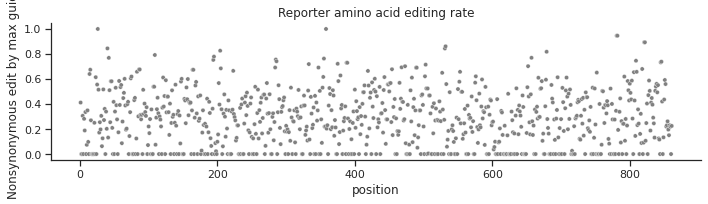

In [143]:
fig, ax= plt.subplots(figsize=(10, 3))
sns.scatterplot(max_aa_edit_rate, x= 'pos', y='mean_edit_rates', ax= ax, c = 'grey', size=1)
ax.get_legend().remove()
ax.set_xlabel("position")
ax.set_ylabel("Nonsynonymous edit by max guide")
ax.set_title("Reporter amino acid editing rate")
plt.savefig("Sb_aa_coverage.pdf", bbox_inches="tight")

In [119]:
(max_aa_edit_rate.mean_edit_rates > 0.1).sum()/len(max_aa_edit_rate)

0.7421602787456446